In [1]:
# Sales Performance Dashboard — End-to-End Project
# Dataset: Sample - Superstore.csv
# Goal: Analyze sales performance, visualize trends, forecast sales, and create report

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import getSampleStyleSheet
import warnings
warnings.filterwarnings('ignore')


In [2]:
# File paths
INPUT_CSV = r"D:\Data Analytics notes\portofolio project development\Sales Performance Optimization for Superstore\project\Sample - Superstore.csv"
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def fmt_currency(x, pos=None):
    if x >= 1e6: return f"{x/1e6:.1f}M"
    elif x >= 1e3: return f"{x/1e3:.0f}k"
    return f"{x:.0f}"

def save_fig(fig, fname):
    path = os.path.join(OUT_DIR, fname)
    fig.savefig(path, bbox_inches='tight', dpi=150)
    print("📊 Saved:", path)


In [3]:
# File paths
INPUT_CSV = r"D:\Data Analytics notes\portofolio project development\Sales Performance Optimization for Superstore\project\Sample - Superstore.csv"
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def fmt_currency(x, pos=None):
    if x >= 1e6: return f"{x/1e6:.1f}M"
    elif x >= 1e3: return f"{x/1e3:.0f}k"
    return f"{x:.0f}"

def save_fig(fig, fname):
    path = os.path.join(OUT_DIR, fname)
    fig.savefig(path, bbox_inches='tight', dpi=150)
    print("📊 Saved:", path)


In [4]:
def load_data(path):
    try:
        df = pd.read_csv(path)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding='latin1')
    return df

df = load_data(INPUT_CSV)
print("✅ Data loaded successfully! Shape:", df.shape)
df.head()


✅ Data loaded successfully! Shape: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
def clean_data(df):
    df.columns = [c.strip() for c in df.columns]
    df = df.drop_duplicates().reset_index(drop=True)

    df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
    df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

    df['Order_Year'] = df['Order Date'].dt.year
    df['Order_Month'] = df['Order Date'].dt.month
    df['Order_MonthName'] = df['Order Date'].dt.strftime('%b')
    df['Order_MonthStart'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()

    for col in ['Sales','Quantity','Discount','Profit']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['Profit_Margin'] = np.where(df['Sales']!=0, df['Profit']/df['Sales'], np.nan)
    return df.dropna(subset=['Order Date','Sales'])

df = clean_data(df)
print("✅ Cleaned dataset:", df.shape)
df.head()

✅ Cleaned dataset: (9994, 26)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product Name,Sales,Quantity,Discount,Profit,Order_Year,Order_Month,Order_MonthName,Order_MonthStart,Profit_Margin
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,11,Nov,2016-11-01,0.1600
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,11,Nov,2016-11-01,0.3000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,6,Jun,2016-06-01,0.4700
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,10,Oct,2015-10-01,-0.4000
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,10,Oct,2015-10-01,0.1125


In [6]:
def clean_data(df):
    df.columns = [c.strip() for c in df.columns]
    df = df.drop_duplicates().reset_index(drop=True)

    df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
    df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

    df['Order_Year'] = df['Order Date'].dt.year
    df['Order_Month'] = df['Order Date'].dt.month
    df['Order_MonthName'] = df['Order Date'].dt.strftime('%b')
    df['Order_MonthStart'] = df['Order Date'].dt.to_period('M').dt.to_timestamp()

    for col in ['Sales','Quantity','Discount','Profit']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df['Profit_Margin'] = np.where(df['Sales']!=0, df['Profit']/df['Sales'], np.nan)
    return df.dropna(subset=['Order Date','Sales'])

df = clean_data(df)
print("✅ Cleaned dataset:", df.shape)
df.head()

✅ Cleaned dataset: (9994, 26)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product Name,Sales,Quantity,Discount,Profit,Order_Year,Order_Month,Order_MonthName,Order_MonthStart,Profit_Margin
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016,11,Nov,2016-11-01,0.1600
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016,11,Nov,2016-11-01,0.3000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016,6,Jun,2016-06-01,0.4700
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015,10,Oct,2015-10-01,-0.4000
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015,10,Oct,2015-10-01,0.1125


In [7]:
total_sales = df['Sales'].sum()
total_profit = df['Profit'].sum()
avg_margin = df['Profit_Margin'].mean()*100

cat_sales = df.groupby('Category')['Sales'].sum().sort_values(ascending=False)
reg_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
mon_sales = df.groupby('Order_MonthStart')['Sales'].sum()

print(f"Total Sales: {total_sales:,.0f}")
print(f"Total Profit: {total_profit:,.0f}")
print(f"Average Profit Margin: {avg_margin:.2f}%")


Total Sales: 2,297,201
Total Profit: 286,397
Average Profit Margin: 12.03%


📊 Saved: outputs\01_monthly_sales.png


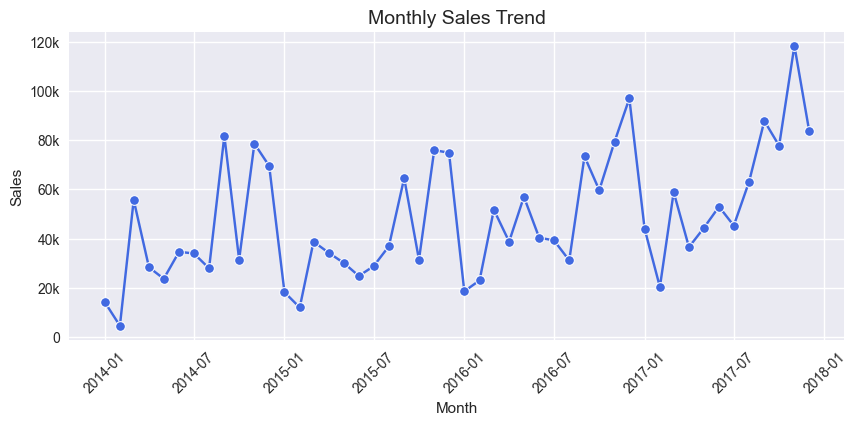

📊 Saved: outputs\02_sales_by_category.png


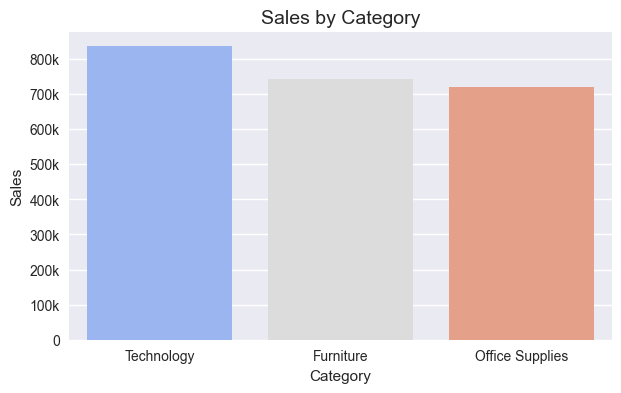

📊 Saved: outputs\03_sales_by_region.png


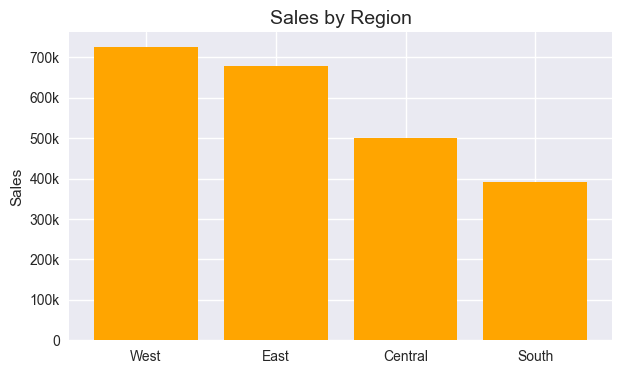

📊 Saved: outputs\04_profit_vs_discount.png


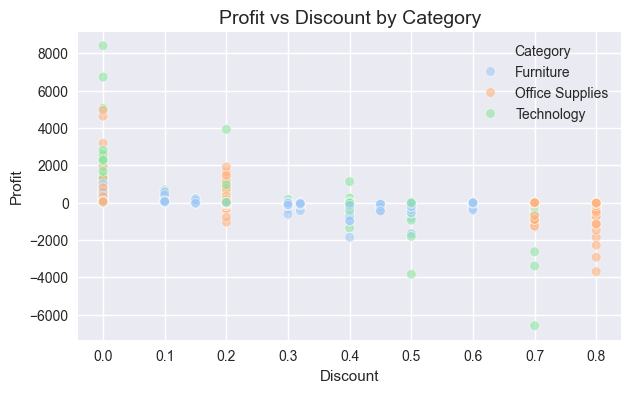

📊 Saved: outputs\05_correlation_heatmap.png


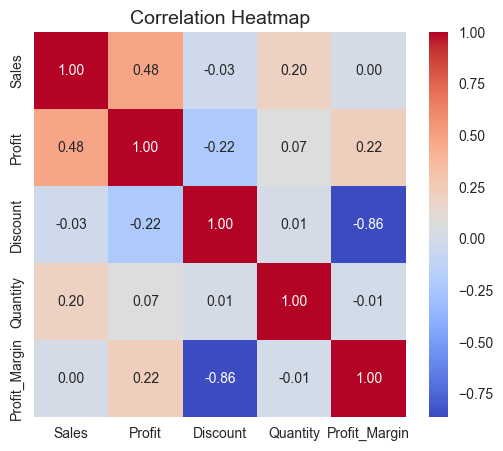

✅ Matplotlib + Seaborn visualizations generated successfully.


In [8]:
plt.style.use('seaborn-v0_8')
sns.set_palette("pastel")

# 1️⃣ Monthly Sales Trend — Lineplot (Seaborn)
fig, ax = plt.subplots(figsize=(10,4))
sns.lineplot(x=mon_sales.index, y=mon_sales.values, marker='o', color='royalblue', ax=ax)
ax.set_title("Monthly Sales Trend", fontsize=14)
ax.set_xlabel("Month")
ax.set_ylabel("Sales")
ax.yaxis.set_major_formatter(FuncFormatter(fmt_currency))
plt.xticks(rotation=45)
save_fig(fig, "01_monthly_sales.png")
plt.show()

# 2️⃣ Sales by Category — Barplot (Seaborn)
fig, ax = plt.subplots(figsize=(7,4))
sns.barplot(x=cat_sales.index, y=cat_sales.values, palette="coolwarm", ax=ax)
ax.set_title("Sales by Category", fontsize=14)
ax.set_ylabel("Sales")
ax.yaxis.set_major_formatter(FuncFormatter(fmt_currency))
save_fig(fig, "02_sales_by_category.png")
plt.show()

# 3️⃣ Sales by Region — Barplot (Matplotlib)
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(reg_sales.index, reg_sales.values, color='orange')
ax.set_title("Sales by Region", fontsize=14)
ax.set_ylabel("Sales")
ax.yaxis.set_major_formatter(FuncFormatter(fmt_currency))
save_fig(fig, "03_sales_by_region.png")
plt.show()

# 4️⃣ Profit vs Discount — Scatter (Seaborn)
fig, ax = plt.subplots(figsize=(7,4))
sns.scatterplot(data=df, x='Discount', y='Profit', hue='Category', alpha=0.6, ax=ax)
ax.set_title("Profit vs Discount by Category", fontsize=14)
save_fig(fig, "04_profit_vs_discount.png")
plt.show()

# 5️⃣ Correlation Heatmap (Seaborn)
num_cols = ['Sales','Profit','Discount','Quantity','Profit_Margin']
corr = df[num_cols].corr()
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
ax.set_title("Correlation Heatmap", fontsize=14)
save_fig(fig, "05_correlation_heatmap.png")
plt.show()

print("✅ Matplotlib + Seaborn visualizations generated successfully.")


In [9]:
monthly = df.groupby('Order_MonthStart')['Sales'].sum().asfreq('MS')
model = SARIMAX(monthly, order=(1,1,1), seasonal_order=(1,1,1,12))
result = model.fit(disp=False)
forecast = result.get_forecast(6)
pred = forecast.predicted_mean
conf = forecast.conf_int()

fig, ax = plt.subplots(figsize=(10,4))
monthly.plot(ax=ax, label='Actual', color='steelblue')
pred.plot(ax=ax, label='Forecast', color='red', linestyle='--')
ax.fill_between(conf.index, conf.iloc[:,0], conf.iloc[:,1], color='gray', alpha=0.3)
ax.set_title("6-Month Sales Forecast (SARIMAX)")
ax.yaxis.set_major_formatter(FuncFormatter(fmt_currency))
ax.legend()
save_fig(fig, "05_sales_forecast.png")
plt.close(fig)


📊 Saved: outputs\05_sales_forecast.png


In [10]:
pdf_path = os.path.join(OUT_DIR, "Sales_Report.pdf")
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
styles = getSampleStyleSheet()
story = [
    Paragraph("Superstore Sales Performance Report", styles['Title']),
    Spacer(1, 12),
    Paragraph(f"Total Sales: ₹{total_sales:,.0f}", styles['Normal']),
    Paragraph(f"Total Profit: ₹{total_profit:,.0f}", styles['Normal']),
    Paragraph(f"Average Profit Margin: {avg_margin:.2f}%", styles['Normal']),
    Spacer(1, 12),
    Paragraph("Key Charts", styles['Heading2'])
]

for img in [
    "01_monthly_sales.png",
    "02_sales_by_category.png",
    "03_sales_by_region.png",
    "04_profit_vs_discount.png",
    "05_sales_forecast.png"
]:
    story.append(Image(os.path.join(OUT_DIR, img), width=400, height=250))
    story.append(Spacer(1, 12))

doc.build(story)
print("✅ PDF Report generated at:", pdf_path)


✅ PDF Report generated at: outputs\Sales_Report.pdf


In [11]:
print("\nTop Categories:\n", cat_sales.head())
print("\nTop Regions:\n", reg_sales.head())
print("\nForecasted 6 Months Sales:\n", pred)



Top Categories:
 Category
Technology         836154.0330
Furniture          741999.7953
Office Supplies    719047.0320
Name: Sales, dtype: float64

Top Regions:
 Region
West       725457.8245
East       678781.2400
Central    501239.8908
South      391721.9050
Name: Sales, dtype: float64

Forecasted 6 Months Sales:
 2018-01-01    43779.923982
2018-02-01    34645.617830
2018-03-01    70715.336429
2018-04-01    54275.318715
2018-05-01    62701.487284
2018-06-01    63612.261373
Freq: MS, Name: predicted_mean, dtype: float64
